In [10]:
!

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import soundfile as sf
from PIL import Image
from google.colab import drive
import os
from IPython.display import display
import matplotlib.pyplot as plt

drive.mount('/content/drive')

os.chdir('//content/drive/MyDrive/NeuralNetFinalProj/Saved')
audio_folders = [folder for folder in os.listdir() if os.path.isdir(folder)]
save_dir = '/content/drive/MyDrive/NeuralNetFinalProj/Saved'  # Note: Changed from os.chdir to a variable


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import numpy as np
from keras.utils import Sequence
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

class CustomAudioSpectrogramDataset(Sequence):
    def __init__(self, dataset_type, datadir, transform):
        self.transform = transform
        self.all_images = []
        self.labels = []

        for index, folder in enumerate(audio_folders[:]):
            folder_path = os.path.join(datadir, folder)
            print("folder is ", folder)

            file_list = os.listdir(folder_path)
            # Sort the file list to ensure same random order
            random.seed(200)
            random.shuffle(file_list)

            if dataset_type == 1:
                start_idx = 0
                end_idx = int(0.8 * len(file_list))
            elif dataset_type == 2:
                start_idx = int(0.8 * len(file_list))
                end_idx = int(0.9 * len(file_list))
            elif dataset_type == 3:
                start_idx = int(0.9 * len(file_list))
                end_idx = len(file_list)
            else:
                raise ValueError("Invalid dataset_type. Supported values are 1, 2, or 3.")

            for i in range(start_idx, end_idx):
                a_file = file_list[i]
                file_path = os.path.join(folder_path, a_file)

                if os.path.isdir(file_path):
                    filename_parts = a_file.split('-')
                    if len(filename_parts) >= 3 and filename_parts[2].isdigit():
                        output_value = int(filename_parts[2]) - 1
                        self.labels.append(output_value)

                        for file in os.listdir(file_path):
                            if "amplitude" in file and file.endswith(".png"):
                                image_path = os.path.join(file_path, file)
                                self.all_images.append(image_path)

        # Convert lists to NumPy arrays
        self.all_images = np.array(self.all_images)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)

        # Convert combined tensor image to float and scale to [0.0, 1.0]
        combined_image = img_array / 225.0

        # Apply transformations using the flow method
        #combined_image = self.transform.flow(np.expand_dims(combined_image, axis=0)).next()

        return combined_image, self.labels[idx]

# Define transformations
transformations = image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
)

# Create dataset instances
datadir = "/content/drive/MyDrive/NeuralNetFinalProj/Saved"
train_dataset = CustomAudioSpectrogramDataset(1, datadir, transform=transformations)
val_dataset = CustomAudioSpectrogramDataset(2, datadir, transform=transformations)
test_dataset = CustomAudioSpectrogramDataset(3, datadir, transform=transformations)

# Convert datasets to NumPy arrays
X_train, y_train = np.array([train_dataset[i][0] for i in range(len(train_dataset))]), np.array(train_dataset.labels)
X_val, y_val = np.array([val_dataset[i][0] for i in range(len(val_dataset))]), np.array(val_dataset.labels)
X_test, y_test = np.array([test_dataset[i][0] for i in range(len(test_dataset))]), np.array(test_dataset.labels)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


folder is  Actor_01
folder is  Actor_08
folder is  Actor_09
folder is  Actor_05
folder is  Actor_06
folder is  Actor_04
folder is  Actor_07
folder is  Actor_10
folder is  Actor_03
folder is  Actor_02
folder is  Actor_11
folder is  Actor_12
folder is  Actor_13
folder is  Actor_14
folder is  Actor_22
folder is  Actor_19
folder is  Actor_16
folder is  Actor_20
folder is  Actor_23
folder is  Actor_21
folder is  Actor_15
folder is  Actor_24
folder is  Actor_17
folder is  Actor_18
folder is  Actor_01
folder is  Actor_08
folder is  Actor_09
folder is  Actor_05
folder is  Actor_06
folder is  Actor_04
folder is  Actor_07
folder is  Actor_10
folder is  Actor_03
folder is  Actor_02
folder is  Actor_11
folder is  Actor_12
folder is  Actor_13
folder is  Actor_14
folder is  Actor_22
folder is  Actor_19
folder is  Actor_16
folder is  Actor_20
folder is  Actor_23
folder is  Actor_21
folder is  Actor_15
folder is  Actor_24
folder is  Actor_17
folder is  Actor_18
folder is  Actor_01
folder is  Actor_08


In [13]:
!pip install torchkeras

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)       

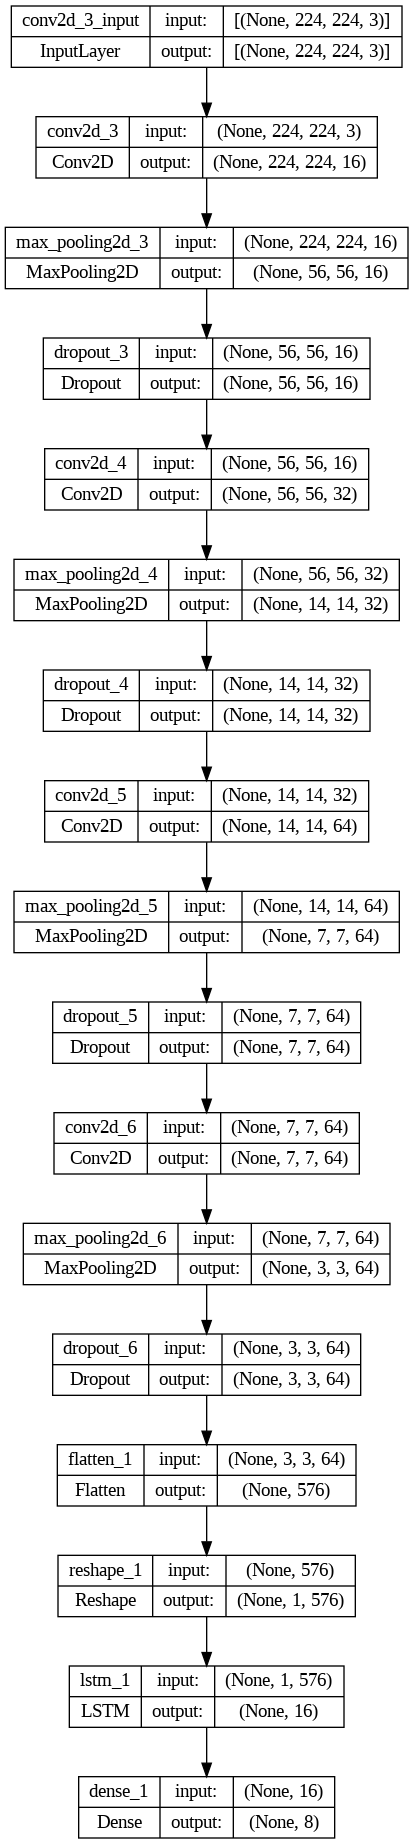

In [14]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from keras.layers import *
from keras.models import Sequential
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
import torchkeras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

height = 224
width = 224

# Define the model
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(height, width, 3)))
model.add(MaxPooling2D(4, 4))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(4, 4))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))

model.add(Flatten())

# Reshape to add a sequence dimension
model.add(Reshape((1, -1)))

# Add LSTM layer
model.add(LSTM(units=16, activation='relu'))  # You can adjust the number of units as needed

# Dense layer
model.add(Dense(8, activation='softmax'))  # Assuming you have 8 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

plot_model(model, to_file='model_view.png', show_shapes=True, show_layer_names=True)



In [15]:

train_labels_categorical = to_categorical(y_train)
val_labels_categorical = to_categorical(y_val)
test_labels_categorical = to_categorical(y_test)
print(len(train_labels_categorical))
print(len(train_labels_categorical[0]))
print(X_train.shape)
print(train_labels_categorical.shape)

# Train the model using fit
model.fit(X_train, train_labels_categorical, epochs=100, validation_data=(X_val, val_labels_categorical))


1152
8
(1152, 224, 224, 3)
(1152, 8)
Epoch 1/100
36/36 [==============================] - 59s 2s/step - loss: 2.0701 - accuracy: 0.1328 - val_loss: 2.0862 - val_accuracy: 0.0972
Epoch 2/100
36/36 [==============================] - 33s 865ms/step - loss: 2.0543 - accuracy: 0.1345 - val_loss: 2.0961 - val_accuracy: 0.0972
Epoch 3/100
36/36 [==============================] - 31s 855ms/step - loss: 2.0504 - accuracy: 0.1319 - val_loss: 2.1084 - val_accuracy: 0.0764
Epoch 4/100
36/36 [==============================] - 33s 928ms/step - loss: 2.0432 - accuracy: 0.1484 - val_loss: 2.0903 - val_accuracy: 0.0833
Epoch 5/100
36/36 [==============================] - 33s 915ms/step - loss: 2.0450 - accuracy: 0.1207 - val_loss: 2.1177 - val_accuracy: 0.1042
Epoch 6/100
36/36 [==============================] - 33s 923ms/step - loss: 2.0403 - accuracy: 0.1467 - val_loss: 2.1176 - val_accuracy: 0.0764
Epoch 7/100
36/36 [==============================] - 33s 921ms/step - loss: 2.0403 - accuracy: 0.1484 

In [16]:

print(X_test.size)
print(test_labels_categorical.size)
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, test_labels_categorical)
print(f'Test accuracy: {test_acc}')

21676032
1152
5/5 [==============================] - 1s 261ms/step - loss: 2.5999 - accuracy: 0.4375
Test accuracy: 0.4375


In [17]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_actual = np.argmax(test_labels_categorical, axis=1)

# Calculate and print the confusion matrix
cm = confusion_matrix(y_pred_class, y_actual)
print("Confusion matrix:")
print(cm)

# Calculate and print the classification report
cr = classification_report(y_pred_class, y_actual)
print("Classification report:")
print(cr)


5/5 [==============================] - 2s 279ms/step
Confusion matrix:
[[12  2  1  0  0  0  0  0]
 [ 4 18  2  0  0  1  2  2]
 [ 8  2  2  1  0  2  0  3]
 [ 3  3  0  0  0  1  3  4]
 [ 0  1  2  0  0  3  5  3]
 [ 1  0  1  0  0  6  3  7]
 [ 0  2  2  0  0  0 18  1]
 [ 2  1  2  0  0  1  0  7]]
Classification report:
              precision    recall  f1-score   support

           0       0.40      0.80      0.53        15
           1       0.62      0.62      0.62        29
           2       0.17      0.11      0.13        18
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        14
           5       0.43      0.33      0.38        18
           6       0.58      0.78      0.67        23
           7       0.26      0.54      0.35        13

    accuracy                           0.44       144
   macro avg       0.31      0.40      0.33       144
weighted avg       0.36      0.44      0.38       144



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓⚓